In [65]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense,Flatten,Input,Dropout,Add,Multiply, Conv2D,  Activation, GlobalAveragePooling2D,Lambda
from tensorflow.keras.layers import  MaxPooling2D,GlobalMaxPooling2D,Reshape,Concatenate,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import os
from tensorflow.keras.utils import plot_model

In [37]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=16096)]
        )
    except RuntimeError as e:
        print(e)

In [38]:
base_dir = '/kaggle/input/wheat-plant-diseases/data'
subdirs = ['train', 'test', 'valid']

In [39]:
data = []
for split in ['train', 'valid', 'test']:
    split_path = os.path.join(base_dir, split)
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                if '_test' in class_name:
                        data.append({'filepath': img_path, 'label': class_name.replace('_test','')})
                elif  '_valid' in class_name:
                        data.append({'filepath': img_path, 'label': class_name.replace('_valid','')})
                else:
                       data.append({'filepath': img_path, 'label': class_name})


In [40]:
df = pd.DataFrame(data)

In [41]:
df.head()

,filepath,label
0,/kaggle/input/wheat-plant-diseases/data/train/...,Yellow Rust
1,/kaggle/input/wheat-plant-diseases/data/train/...,Yellow Rust
2,/kaggle/input/wheat-plant-diseases/data/train/...,Yellow Rust
3,/kaggle/input/wheat-plant-diseases/data/train/...,Yellow Rust
4,/kaggle/input/wheat-plant-diseases/data/train/...,Yellow Rust


In [42]:
def changeLabel(x):
    if x == 'mildew':
        return 'Mildew'
    elif x == 'leaf_blight':
        return 'Leaf Blight'
    elif x == 'yellow_rust':
        return 'Yellow Rust'
    elif x == 'stem_fly':
        return 'Stem fly'
    elif x == 'fusarium_head_blight':
        return 'Fusarium Head Blight'
    elif x == 'brown_rust':
        return 'Brown Rust'
    elif x == 'smut':
        return 'Smut'
    elif x == 'healthy':
        return 'Healthy'
    elif x == 'black_rust':
        return 'Black Rust'
    elif x == 'mite':
        return 'Mite'
    elif x == 'blast_valid':
        return 'Blast'
    elif x == 'aphid':
        return 'Aphid'
    elif x == 'tan_spot':
        return 'Tan spot'
    elif x == 'common_root_rot':
        return 'Common Root Rot'
    elif x == 'septoria':
        return 'Septoria'
    elif x == 'blast':
        return 'Blast'
    else:
        return x


In [43]:
df['label'] = df['label'].apply(changeLabel)

In [44]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [45]:
def apply_clahe(image):
    image = np.array(image, dtype=np.uint8)
    if image.ndim == 3 and image.shape[2] == 3:
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        lab = cv2.merge((cl, a, b))
        enhanced_img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    else:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced_img = clahe.apply(image)
    return enhanced_img.astype('float32')

In [46]:
train_datagen = ImageDataGenerator(
    preprocessing_function=apply_clahe,
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=apply_clahe,
    rescale=1./255
)

In [47]:
train_data = train_datagen.flow_from_dataframe(train_df,
                                            x_col='filepath',
                                            y_col='label',
                                          target_size=(224,224),
                                          class_mode='categorical',
                                          batch_size=32)

Found 9907 validated image filenames belonging to 15 classes.


In [48]:
valid_data = train_datagen.flow_from_dataframe(valid_df,
                                            x_col='filepath',
                                            y_col='label',
                                          target_size=(224,224),
                                          class_mode='categorical',
                                          batch_size=32)

Found 2123 validated image filenames belonging to 15 classes.


In [49]:
train_classes = train_data.classes
class_weights = compute_class_weight('balanced', classes=np.unique(train_classes), y=train_classes)
class_weights = dict(enumerate(class_weights))

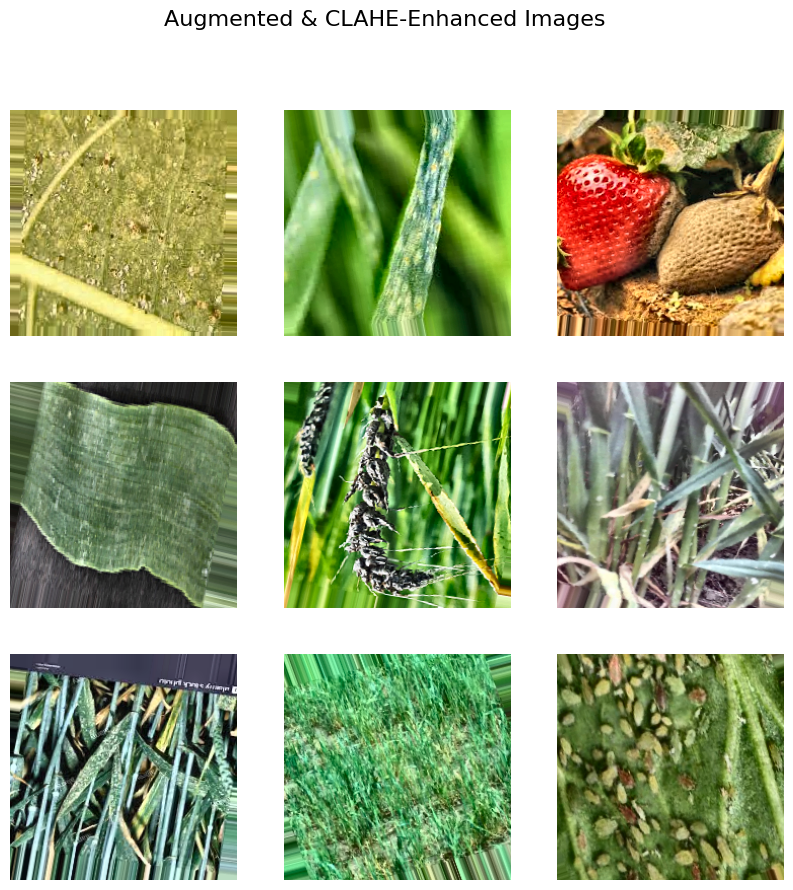

In [50]:
images, labels = next(train_data)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow((images[i] * 255).astype(np.uint8))
    plt.axis('off')
plt.suptitle("Augmented & CLAHE-Enhanced Images", fontsize=16)
plt.show()

In [51]:
train_classes = list(train_data.class_indices.keys())
train_classes

['Aphid',
 'Black Rust',
 'Blast',
 'Brown Rust',
 'Common Root Rot',
 'Fusarium Head Blight',
 'Healthy',
 'Leaf Blight',
 'Mildew',
 'Mite',
 'Septoria',
 'Smut',
 'Stem fly',
 'Tan spot',
 'Yellow Rust']

In [52]:
num_classes = len(train_data.class_indices)
num_classes

15

In [53]:
def channel_attention(input_feature, reduction_ratio=8):
    channels = input_feature.shape[-1]
    avg_pool = GlobalAveragePooling2D()(input_feature)
    max_pool = GlobalMaxPooling2D()(input_feature)

    shared_dense = Dense(channels // reduction_ratio, activation='relu',use_bias=False)
    shared_dense_out = Dense(channels, activation='sigmoid',use_bias=False)

    avg_out = shared_dense_out(shared_dense(avg_pool))
    max_out = shared_dense_out(shared_dense(max_pool))

    scale = avg_out + max_out
    scale = Activation('sigmoid')(scale)

    return Multiply()([input_feature, scale])

In [54]:
def spatial_attention(input_feature):
    avg_pool = Lambda(lambda x: tf.expand_dims(tf.reduce_mean(x, axis=-1), axis=-1))(input_feature)
    max_pool = Lambda(lambda x: tf.expand_dims(tf.reduce_max(x, axis=-1), axis=-1))(input_feature)

    concat = Concatenate()([avg_pool, max_pool])
    attention_map = Conv2D(filters=1, kernel_size=7, padding="same", activation='sigmoid')(concat)

    return Multiply()([input_feature, attention_map])

# Example usage
i = Input(shape=(224, 224, 3))
x = spatial_attention(i)

print(x.shape)

(None, 224, 224, 3)


In [55]:
def cbam_block(input_feature):
    x = channel_attention(input_feature)
    x = spatial_attention(x)
    return x

In [58]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
# Insert CBAM in a few layers
x = base_model.output
x = cbam_block(x)  # Add CBAM to the last feature map
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)  # Adjust output classes as needed

# Final Model
cbam_model = Model(inputs=base_model.input, outputs=x)

# Compile
cbam_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
history = cbam_model.fit(train_data,validation_data=valid_data,epochs=10,class_weight=class_weights)

Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 301s 930ms/step - accuracy: 0.4720 - loss: 1.7124 - val_accuracy: 0.6382 - val_loss: 1.0698
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 288s 912ms/step - accuracy: 0.6754 - loss: 0.9804 - val_accuracy: 0.6825 - val_loss: 0.9768
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 285s 900ms/step - accuracy: 0.7111 - loss: 0.8671 - val_accuracy: 0.6905 - val_loss: 0.9202
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 285s 901ms/step - accuracy: 0.7431 - loss: 0.7594 - val_accuracy: 0.7061 - val_loss: 0.8796
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 286s 905ms/step - accuracy: 0.7666 - loss: 0.6842 - val_accuracy: 0.7089 - val_loss: 0.8771
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 285s 904ms/step - accuracy: 0.7720 - loss: 0.6562 - val_accuracy: 0.7358 - val_loss: 0.8382
Epoch 7/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 285s 904ms/step - accuracy: 0.7913 - loss: 0.6078 - val_accuracy: 0.7419 - val_loss: 0.7798
Epoch 8/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 285s 901ms/step - accuracy: 0.8191 -

In [61]:
def BAM(x):
    ca = channel_attention(x)
    sa = spatial_attention(ca)
    return Add()([x, sa])

In [1]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
x = base_model.output
x = BAM(x)
x = GlobalAveragePooling2D()(x)
x = Dense(num_classes, activation='softmax')(x)
bam_model = tf.keras.Model(inputs=base_model.input, outputs=x)

NameError: name 'tf' is not defined

In [67]:
bam_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
bam_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,686,898 (10.25 MB)

 Trainable params: 428,914 (1.64 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [68]:
bam_history = bam_model.fit(train_data,validation_data=valid_data,epochs=10,class_weight=class_weights)

Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 301s 928ms/step - accuracy: 0.3943 - loss: 2.0959 - val_accuracy: 0.6048 - val_loss: 1.2646
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 293s 927ms/step - accuracy: 0.6317 - loss: 1.1461 - val_accuracy: 0.6547 - val_loss: 1.0733
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 285s 903ms/step - accuracy: 0.6778 - loss: 0.9784 - val_accuracy: 0.6703 - val_loss: 1.0355
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 286s 905ms/step - accuracy: 0.6943 - loss: 0.9149 - val_accuracy: 0.6821 - val_loss: 0.9901
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 285s 904ms/step - accuracy: 0.7208 - loss: 0.8444 - val_accuracy: 0.6844 - val_loss: 0.9968
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 286s 905ms/step - accuracy: 0.7340 - loss: 0.7970 - val_accuracy: 0.6896 - val_loss: 0.9603
Epoch 7/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 285s 902ms/step - accuracy: 0.7321 - loss: 0.8173 - val_accuracy: 0.6797 - val_loss: 1.0514
Epoch 8/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 285s 905ms/step - accuracy: 0.7472 -

In [84]:
def build_mobilenetv2_cbam_ssd(input_shape=(224, 224, 3), num_classes=15):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    x = base_model.output
    x = cbam_block(x)  # Apply CBAM after feature extraction
    x = Conv2D(512, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv2D(num_classes + 4, kernel_size=1, padding='same')(x)  # Class + 4 bbox coords
    x = GlobalAveragePooling2D()(x)
    output = Dense(15,activation='sigmoid')(x)  # Adjust activation based on need

    model = Model(inputs=base_model.input, outputs=output)
    return model

# Create model
ssd_model = build_mobilenetv2_cbam_ssd()
ssd_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 8,576,482 (32.72 MB)

 Trainable params: 6,318,498 (24.10 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [85]:
ssd_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [86]:
ssd_history = ssd_model.fit(train_data,validation_data=valid_data,epochs=10,class_weight=class_weights)

Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 321s 983ms/step - accuracy: 0.4362 - loss: 2.1469 - val_accuracy: 0.6175 - val_loss: 1.1228
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 290s 915ms/step - accuracy: 0.6581 - loss: 1.0468 - val_accuracy: 0.6444 - val_loss: 1.0892
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 288s 913ms/step - accuracy: 0.7045 - loss: 0.8657 - val_accuracy: 0.6882 - val_loss: 0.9354
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 288s 912ms/step - accuracy: 0.7449 - loss: 0.7444 - val_accuracy: 0.6985 - val_loss: 0.9081
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 288s 911ms/step - accuracy: 0.7601 - loss: 0.7165 - val_accuracy: 0.7084 - val_loss: 0.8877
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 287s 908ms/step - accuracy: 0.7680 - loss: 0.6548 - val_accuracy: 0.7193 - val_loss: 0.8515
Epoch 7/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 290s 921ms/step - accuracy: 0.7872 - loss: 0.6120 - val_accuracy: 0.7348 - val_loss: 0.8211
Epoch 8/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 287s 908ms/step - accuracy: 0.7929 -

In [87]:
test_data = test_datagen.flow_from_dataframe(test_df,
                                            x_col='filepath',
                                            y_col='label',        
                                          target_size=(224,224),
                                          class_mode='categorical',
                                             shuffle=False,
                                          batch_size=32)

Found 2124 validated image filenames belonging to 15 classes.


In [88]:
cbam_model.evaluate(test_data)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 843ms/step - accuracy: 0.7500 - loss: 0.8438


[0.8201875686645508, 0.7419962286949158]

In [89]:
bam_model.evaluate(test_data)

67/67 ━━━━━━━━━━━━━━━━━━━━ 36s 541ms/step - accuracy: 0.6844 - loss: 1.0569


[1.0091084241867065, 0.6883239150047302]

In [90]:
ssd_model.evaluate(test_data)

67/67 ━━━━━━━━━━━━━━━━━━━━ 36s 539ms/step - accuracy: 0.7475 - loss: 0.8090


[0.7934228181838989, 0.75]

In [91]:
cbam_predictions = cbam_model.predict(test_data)

67/67 ━━━━━━━━━━━━━━━━━━━━ 38s 531ms/step


In [92]:
bam_predictions = bam_model.predict(test_data)

67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 537ms/step


In [93]:
ssd_predictions = ssd_model.predict(test_data)

67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 534ms/step


In [104]:
cbam_cm = confusion_matrix(y_pred=np.argmax(cbam_predictions,axis=1),y_true=test_data.classes)

In [105]:
bam_cm = confusion_matrix(y_pred=np.argmax(bam_predictions,axis=1),y_true=test_data.classes)

In [106]:
ssd_cm = confusion_matrix(y_pred=np.argmax(ssd_predictions,axis=1),y_true=test_data.classes)

In [107]:
import seaborn as sns

<Axes: >

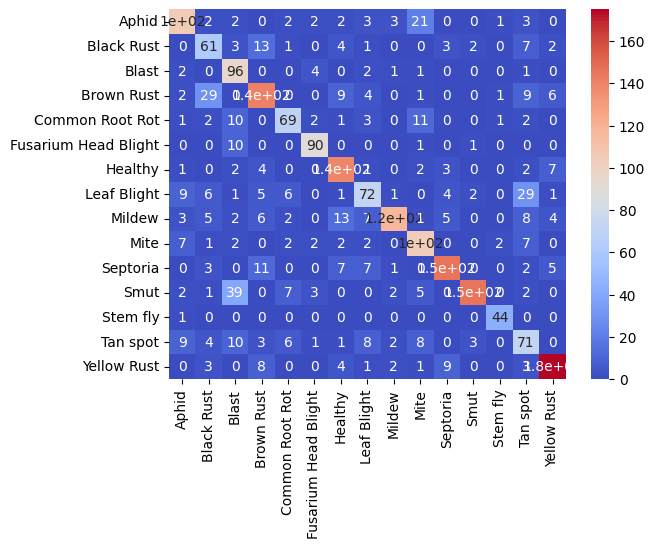

In [108]:
sns.heatmap(cbam_cm,xticklabels=train_classes,yticklabels=train_classes,annot=True,cmap="coolwarm")

<Axes: >

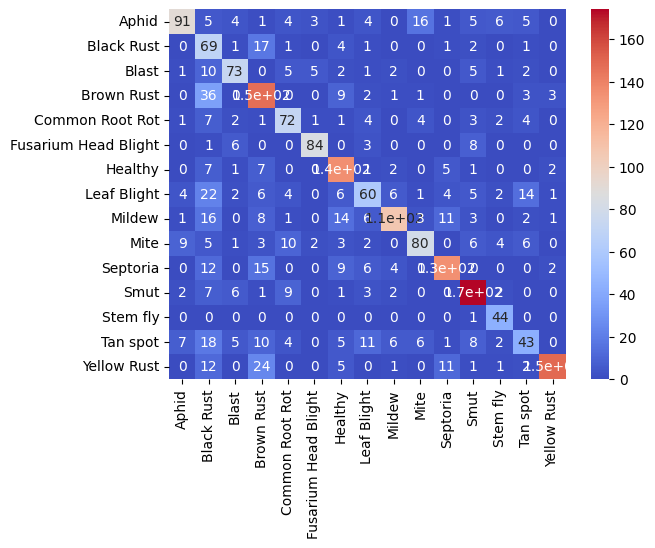

In [109]:
sns.heatmap(bam_cm,xticklabels=train_classes,yticklabels=train_classes,annot=True,cmap="coolwarm")

<Axes: >

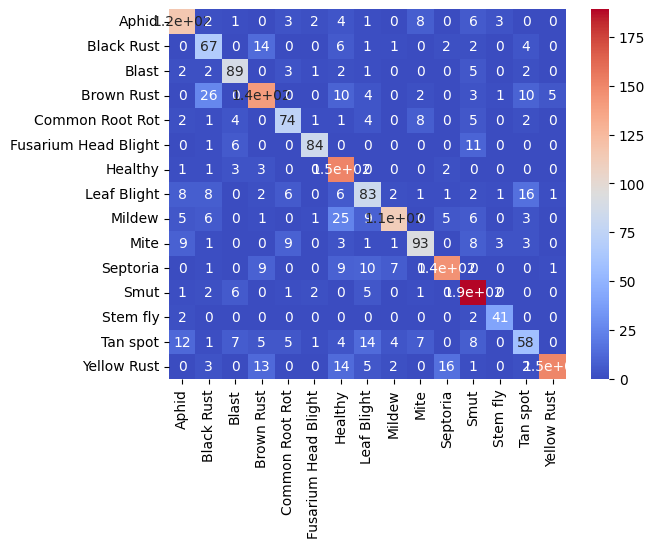

In [110]:
sns.heatmap(ssd_cm,xticklabels=train_classes,yticklabels=train_classes,annot=True,cmap="coolwarm")

In [112]:
print(cbam_cm)

[[105   2   2   0   2   2   2   3   3  21   0   0   1   3   0]
 [  0  61   3  13   1   0   4   1   0   0   3   2   0   7   2]
 [  2   0  96   0   0   4   0   2   1   1   0   0   0   1   0]
 [  2  29   0 141   0   0   9   4   0   1   0   0   1   9   6]
 [  1   2  10   0  69   2   1   3   0  11   0   0   1   2   0]
 [  0   0  10   0   0  90   0   0   0   1   0   1   0   0   0]
 [  1   0   2   4   0   0 139   1   0   2   3   0   0   2   7]
 [  9   6   1   5   6   0   1  72   1   0   4   2   0  29   1]
 [  3   5   2   6   2   0  13   7 117   1   5   0   0   8   4]
 [  7   1   2   0   2   2   2   2   0 104   0   0   2   7   0]
 [  0   3   0  11   0   0   7   7   1   0 146   0   0   2   5]
 [  2   1  39   0   7   3   0   0   2   5   0 146   0   2   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0  44   0   0]
 [  9   4  10   3   6   1   1   8   2   8   0   3   0  71   0]
 [  0   3   0   8   0   0   4   1   2   1   9   0   0   3 175]]


In [113]:
print(bam_cm)

[[ 91   5   4   1   4   3   1   4   0  16   1   5   6   5   0]
 [  0  69   1  17   1   0   4   1   0   0   1   2   0   1   0]
 [  1  10  73   0   5   5   2   1   2   0   0   5   1   2   0]
 [  0  36   0 147   0   0   9   2   1   1   0   0   0   3   3]
 [  1   7   2   1  72   1   1   4   0   4   0   3   2   4   0]
 [  0   1   6   0   0  84   0   3   0   0   0   8   0   0   0]
 [  0   7   1   7   0   0 135   1   2   0   5   1   0   0   2]
 [  4  22   2   6   4   0   6  60   6   1   4   5   2  14   1]
 [  1  16   0   8   1   0  14   6 107   3  11   3   0   2   1]
 [  9   5   1   3  10   2   3   2   0  80   0   6   4   6   0]
 [  0  12   0  15   0   0   9   6   4   0 134   0   0   0   2]
 [  2   7   6   1   9   0   1   3   2   0   0 174   2   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1  44   0   0]
 [  7  18   5  10   4   0   5  11   6   6   1   8   2  43   0]
 [  0  12   0  24   0   0   5   0   1   0  11   1   1   2 149]]


In [114]:
print(ssd_cm)

[[116   2   1   0   3   2   4   1   0   8   0   6   3   0   0]
 [  0  67   0  14   0   0   6   1   1   0   2   2   0   4   0]
 [  2   2  89   0   3   1   2   1   0   0   0   5   0   2   0]
 [  0  26   0 141   0   0  10   4   0   2   0   3   1  10   5]
 [  2   1   4   0  74   1   1   4   0   8   0   5   0   2   0]
 [  0   1   6   0   0  84   0   0   0   0   0  11   0   0   0]
 [  1   1   3   3   0   0 151   0   0   0   2   0   0   0   0]
 [  8   8   0   2   6   0   6  83   2   1   1   2   1  16   1]
 [  5   6   0   1   0   1  25   9 112   0   5   6   0   3   0]
 [  9   1   0   0   9   0   3   1   1  93   0   8   3   3   0]
 [  0   1   0   9   0   0   9  10   7   0 145   0   0   0   1]
 [  1   2   6   0   1   2   0   5   0   1   0 189   0   0   0]
 [  2   0   0   0   0   0   0   0   0   0   0   2  41   0   0]
 [ 12   1   7   5   5   1   4  14   4   7   0   8   0  58   0]
 [  0   3   0  13   0   0  14   5   2   0  16   1   0   2 150]]


In [115]:
cbam_classificationReport = classification_report(y_pred=np.argmax(cbam_predictions,axis=1),y_true=test_data.classes)

In [116]:
bam_classificationReport = classification_report(y_pred=np.argmax(bam_predictions,axis=1),y_true=test_data.classes)

In [117]:
ssd_classificationReport = classification_report(y_pred=np.argmax(ssd_predictions,axis=1),y_true=test_data.classes)

In [118]:
print(cbam_classificationReport)

              precision    recall  f1-score   support

           0       0.74      0.72      0.73       146
           1       0.52      0.63      0.57        97
           2       0.54      0.90      0.68       107
           3       0.74      0.70      0.72       202
           4       0.73      0.68      0.70       102
           5       0.87      0.88      0.87       102
           6       0.76      0.86      0.81       161
           7       0.65      0.53      0.58       137
           8       0.91      0.68      0.77       173
           9       0.67      0.79      0.72       131
          10       0.86      0.80      0.83       182
          11       0.95      0.71      0.81       207
          12       0.90      0.98      0.94        45
          13       0.49      0.56      0.52       126
          14       0.88      0.85      0.86       206

    accuracy                           0.74      2124
   macro avg       0.75      0.75      0.74      2124
weighted avg       0.76   

In [119]:
print(bam_classificationReport)

              precision    recall  f1-score   support

           0       0.78      0.62      0.69       146
           1       0.30      0.71      0.43        97
           2       0.72      0.68      0.70       107
           3       0.61      0.73      0.67       202
           4       0.65      0.71      0.68       102
           5       0.88      0.82      0.85       102
           6       0.69      0.84      0.76       161
           7       0.58      0.44      0.50       137
           8       0.82      0.62      0.70       173
           9       0.72      0.61      0.66       131
          10       0.80      0.74      0.77       182
          11       0.78      0.84      0.81       207
          12       0.69      0.98      0.81        45
          13       0.52      0.34      0.41       126
          14       0.94      0.72      0.82       206

    accuracy                           0.69      2124
   macro avg       0.70      0.69      0.68      2124
weighted avg       0.72   

In [120]:
print(ssd_classificationReport)

              precision    recall  f1-score   support

           0       0.73      0.79      0.76       146
           1       0.55      0.69      0.61        97
           2       0.77      0.83      0.80       107
           3       0.75      0.70      0.72       202
           4       0.73      0.73      0.73       102
           5       0.91      0.82      0.87       102
           6       0.64      0.94      0.76       161
           7       0.60      0.61      0.60       137
           8       0.87      0.65      0.74       173
           9       0.78      0.71      0.74       131
          10       0.85      0.80      0.82       182
          11       0.76      0.91      0.83       207
          12       0.84      0.91      0.87        45
          13       0.58      0.46      0.51       126
          14       0.96      0.73      0.83       206

    accuracy                           0.75      2124
   macro avg       0.75      0.75      0.75      2124
weighted avg       0.76   

In [123]:
cbam_history = history

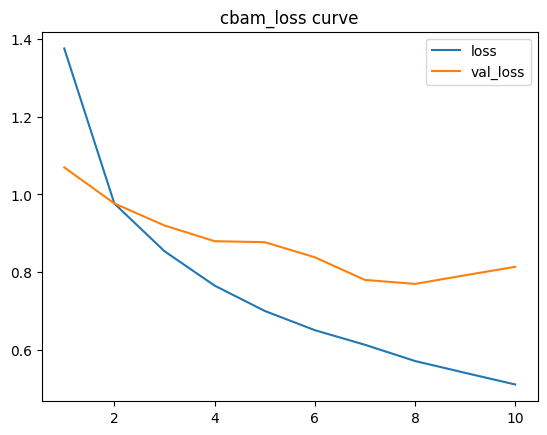

In [124]:
plt.plot(np.arange(1,11),cbam_history.history['loss'],label='loss')
plt.plot(np.arange(1,11),cbam_history.history['val_loss'],label='val_loss')
plt.legend()
plt.title('cbam_loss curve')
plt.show()

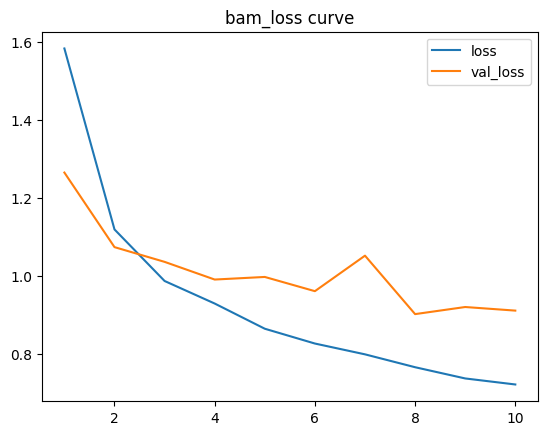

In [122]:
plt.plot(np.arange(1,11),bam_history.history['loss'],label='loss')
plt.plot(np.arange(1,11),bam_history.history['val_loss'],label='val_loss')
plt.legend()
plt.title('bam_loss curve')
plt.show()

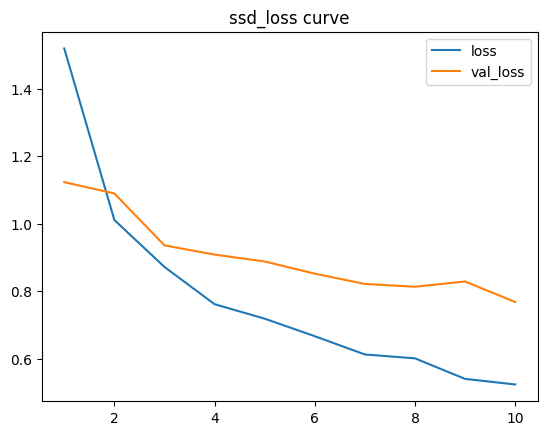

In [125]:
plt.plot(np.arange(1,11),ssd_history.history['loss'],label='loss')
plt.plot(np.arange(1,11),ssd_history.history['val_loss'],label='val_loss')
plt.legend()
plt.title('ssd_loss curve')
plt.show()

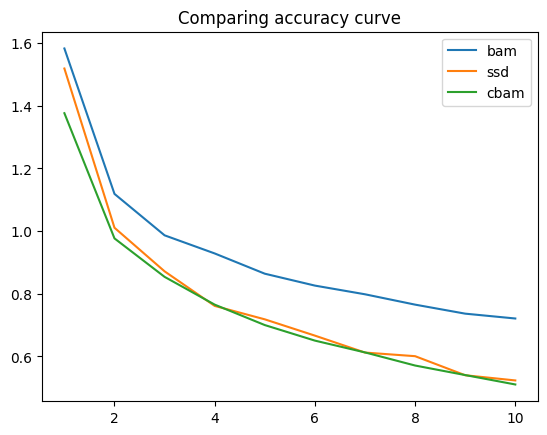

In [126]:
plt.plot(np.arange(1,11),bam_history.history['loss'],label='bam')
plt.plot(np.arange(1,11),ssd_history.history['loss'],label='ssd')
plt.plot(np.arange(1,11),cbam_history.history['loss'],label='cbam')
plt.title('Comparing accuracy curve')
plt.legend()
plt.show()

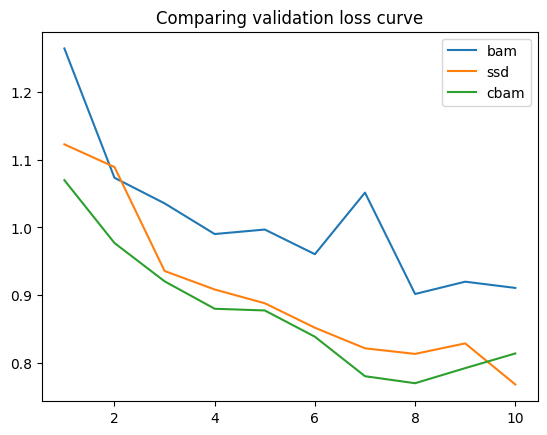

In [128]:
plt.plot(np.arange(1,11),bam_history.history['val_loss'],label='bam')
plt.plot(np.arange(1,11),ssd_history.history['val_loss'],label='ssd')
plt.plot(np.arange(1,11),cbam_history.history['val_loss'],label='cbam')
plt.title('Comparing validation loss curve')
plt.legend()
plt.show()

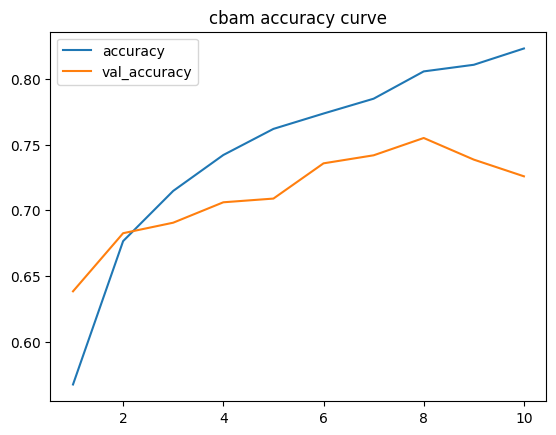

In [129]:
plt.plot(np.arange(1,11),cbam_history.history['accuracy'],label='accuracy')
plt.plot(np.arange(1,11),cbam_history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.title('cbam accuracy curve')
plt.show()

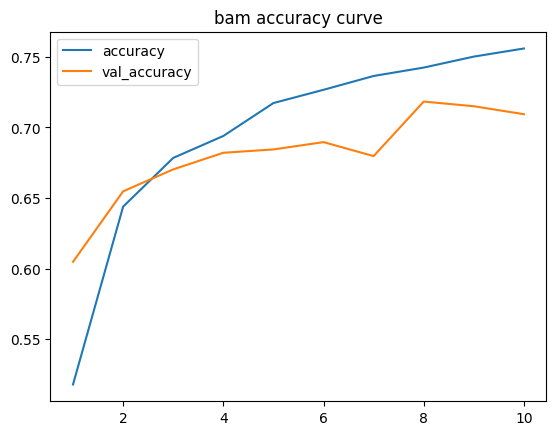

In [130]:
plt.plot(np.arange(1,11),bam_history.history['accuracy'],label='accuracy')
plt.plot(np.arange(1,11),bam_history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.title('bam accuracy curve')
plt.show()

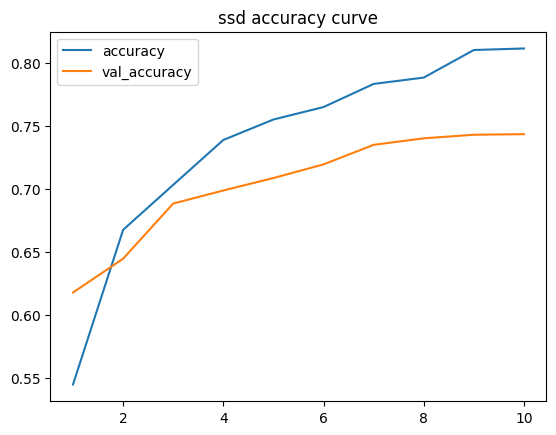

In [131]:
plt.plot(np.arange(1,11),ssd_history.history['accuracy'],label='accuracy')
plt.plot(np.arange(1,11),ssd_history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.title('ssd accuracy curve')
plt.show()

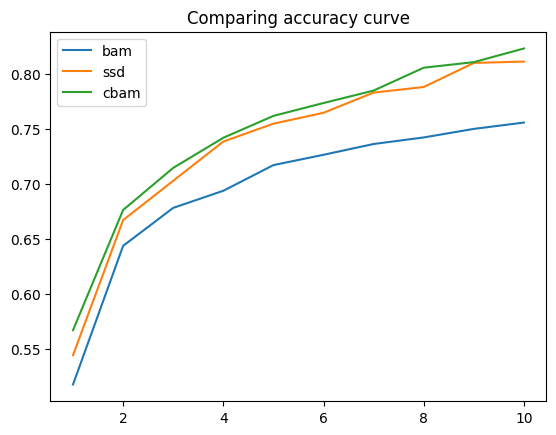

In [132]:
plt.plot(np.arange(1,11),bam_history.history['accuracy'],label='bam')
plt.plot(np.arange(1,11),ssd_history.history['accuracy'],label='ssd')
plt.plot(np.arange(1,11),cbam_history.history['accuracy'],label='cbam')
plt.title('Comparing accuracy curve')
plt.legend()
plt.show()

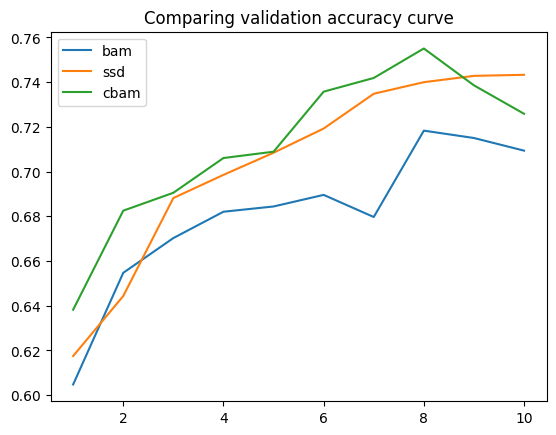

In [133]:
plt.plot(np.arange(1,11),bam_history.history['val_accuracy'],label='bam')
plt.plot(np.arange(1,11),ssd_history.history['val_accuracy'],label='ssd')
plt.plot(np.arange(1,11),cbam_history.history['val_accuracy'],label='cbam')
plt.title('Comparing validation accuracy curve')
plt.legend()
plt.show()

In [135]:
cbam_model.save('cbam.h5')

In [136]:
bam_model.save('bam.h5')

In [137]:
ssd_model.save('ssd.h5')

In [138]:
cbam_df = pd.DataFrame(cbam_history.history)

In [139]:
bam_df = pd.DataFrame(bam_history.history)

In [140]:
ssd_df = pd.DataFrame(ssd_history.history)

In [141]:
cbam_df.to_csv('cbam_data.csv', index=False) 

In [142]:
bam_df.to_csv('bam_data.csv', index=False) 

In [143]:
ssd_df.to_csv('ssd_data.csv', index=False) 

In [145]:
ssd_cr = pd.DataFrame(classification_report(y_pred=np.argmax(ssd_predictions,axis=1),y_true=test_data.classes,output_dict=True)).transpose()
print(ssd_cr)

              precision    recall  f1-score  support
0              0.734177  0.794521  0.763158   146.00
1              0.549180  0.690722  0.611872    97.00
2              0.767241  0.831776  0.798206   107.00
3              0.750000  0.698020  0.723077   202.00
4              0.732673  0.725490  0.729064   102.00
5              0.913043  0.823529  0.865979   102.00
6              0.642553  0.937888  0.762626   161.00
7              0.601449  0.605839  0.603636   137.00
8              0.868217  0.647399  0.741722   173.00
9              0.775000  0.709924  0.741036   131.00
10             0.847953  0.796703  0.821530   182.00
11             0.762097  0.913043  0.830769   207.00
12             0.836735  0.911111  0.872340    45.00
13             0.580000  0.460317  0.513274   126.00
14             0.955414  0.728155  0.826446   206.00
accuracy       0.750000  0.750000  0.750000     0.75
macro avg      0.754382  0.751629  0.746982  2124.00
weighted avg   0.762300  0.750000  0.749282  2

In [146]:
bam_cr = pd.DataFrame(classification_report(y_pred=np.argmax(bam_predictions,axis=1),y_true=test_data.classes,output_dict=True)).transpose()
print(ssd_cr)

              precision    recall  f1-score  support
0              0.734177  0.794521  0.763158   146.00
1              0.549180  0.690722  0.611872    97.00
2              0.767241  0.831776  0.798206   107.00
3              0.750000  0.698020  0.723077   202.00
4              0.732673  0.725490  0.729064   102.00
5              0.913043  0.823529  0.865979   102.00
6              0.642553  0.937888  0.762626   161.00
7              0.601449  0.605839  0.603636   137.00
8              0.868217  0.647399  0.741722   173.00
9              0.775000  0.709924  0.741036   131.00
10             0.847953  0.796703  0.821530   182.00
11             0.762097  0.913043  0.830769   207.00
12             0.836735  0.911111  0.872340    45.00
13             0.580000  0.460317  0.513274   126.00
14             0.955414  0.728155  0.826446   206.00
accuracy       0.750000  0.750000  0.750000     0.75
macro avg      0.754382  0.751629  0.746982  2124.00
weighted avg   0.762300  0.750000  0.749282  2

In [147]:
cbam_cr = pd.DataFrame(classification_report(y_pred=np.argmax(cbam_predictions,axis=1),y_true=test_data.classes,output_dict=True)).transpose()
print(ssd_cr)

              precision    recall  f1-score  support
0              0.734177  0.794521  0.763158   146.00
1              0.549180  0.690722  0.611872    97.00
2              0.767241  0.831776  0.798206   107.00
3              0.750000  0.698020  0.723077   202.00
4              0.732673  0.725490  0.729064   102.00
5              0.913043  0.823529  0.865979   102.00
6              0.642553  0.937888  0.762626   161.00
7              0.601449  0.605839  0.603636   137.00
8              0.868217  0.647399  0.741722   173.00
9              0.775000  0.709924  0.741036   131.00
10             0.847953  0.796703  0.821530   182.00
11             0.762097  0.913043  0.830769   207.00
12             0.836735  0.911111  0.872340    45.00
13             0.580000  0.460317  0.513274   126.00
14             0.955414  0.728155  0.826446   206.00
accuracy       0.750000  0.750000  0.750000     0.75
macro avg      0.754382  0.751629  0.746982  2124.00
weighted avg   0.762300  0.750000  0.749282  2

In [150]:
cbam_cr.to_csv('cbam_cr.csv')
bam_cr.to_csv('bam_cr.csv')
ssd_cr.to_csv('ssd_cr.csv')

In [151]:
from sklearn.metrics import roc_curve, auc

In [154]:
from sklearn.preprocessing import label_binarize

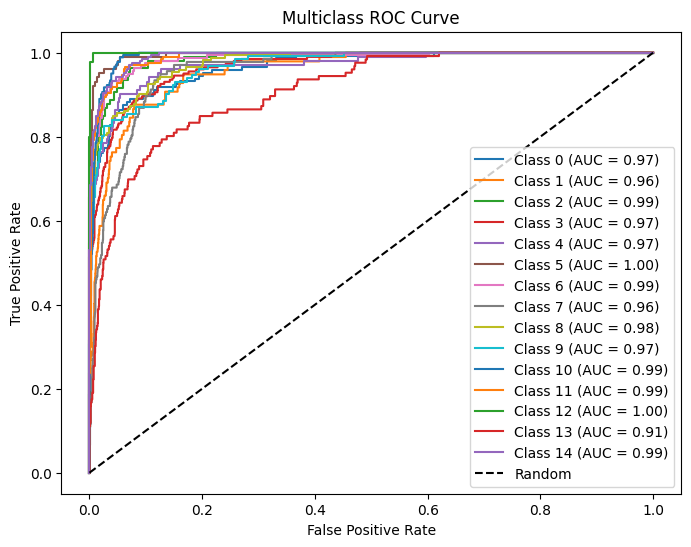

In [155]:
n_classes = len(np.unique(test_data.classes))

# Convert labels to one-hot encoding
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))

# Predicted probabilities (assumed softmax output)
y_pred = cbam_predictions  # Shape: (num_samples, num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('cbam Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

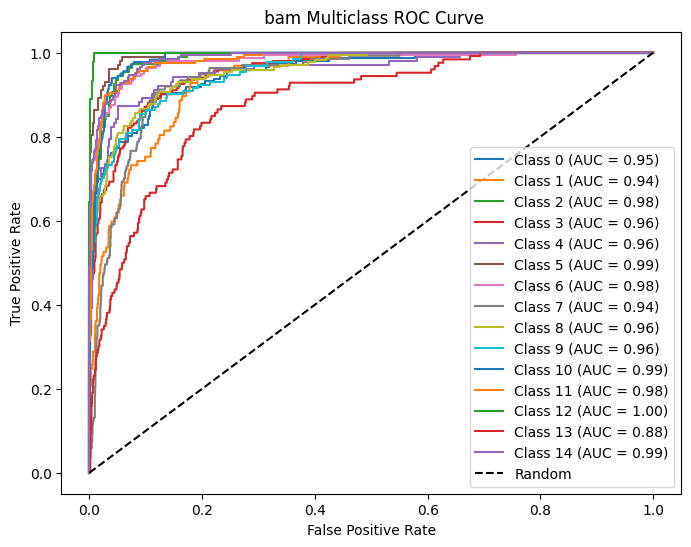

In [156]:
n_classes = len(np.unique(test_data.classes))

# Convert labels to one-hot encoding
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))

# Predicted probabilities (assumed softmax output)
y_pred = bam_predictions  # Shape: (num_samples, num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' bam Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

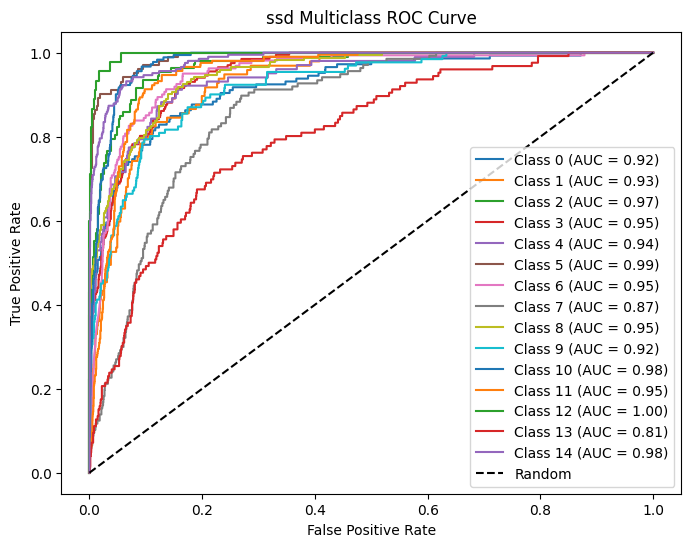

In [157]:
n_classes = len(np.unique(test_data.classes))

# Convert labels to one-hot encoding
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))

# Predicted probabilities (assumed softmax output)
y_pred = ssd_predictions  # Shape: (num_samples, num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ssd Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [158]:
from sklearn.metrics import precision_recall_curve, average_precision_score

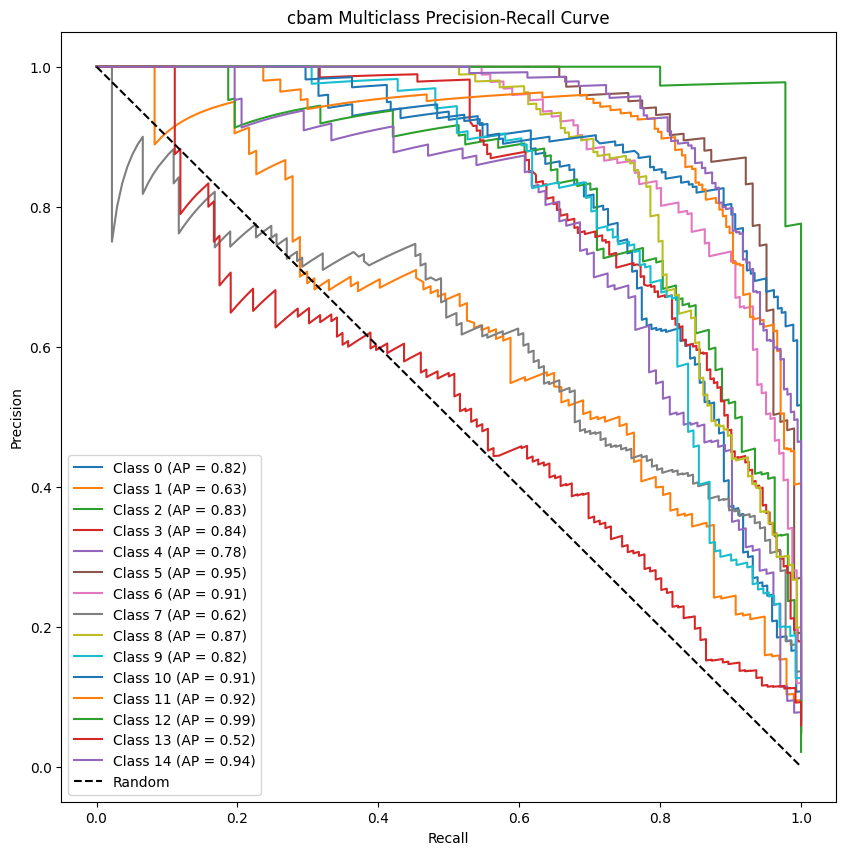

In [161]:
n_classes = len(np.unique(test_data.classes))

# Convert labels to one-hot encoding
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))

# Predicted probabilities (assumed softmax output)
y_pred = cbam_predictions  # Shape: (num_samples, num_classes)

# Compute Precision-Recall curve and Average Precision (AP) for each class
precision = dict()
recall = dict()
average_precision = dict()

plt.figure(figsize=(10, 10))
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])
    
    # Plot Precision-Recall curve for each class
    plt.plot(recall[i], precision[i], label=f'Class {i} (AP = {average_precision[i]:.2f})')

# Random classifier baseline
plt.plot([0, 1], [1, 0], 'k--', label='Random')

# Labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('cbam Multiclass Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


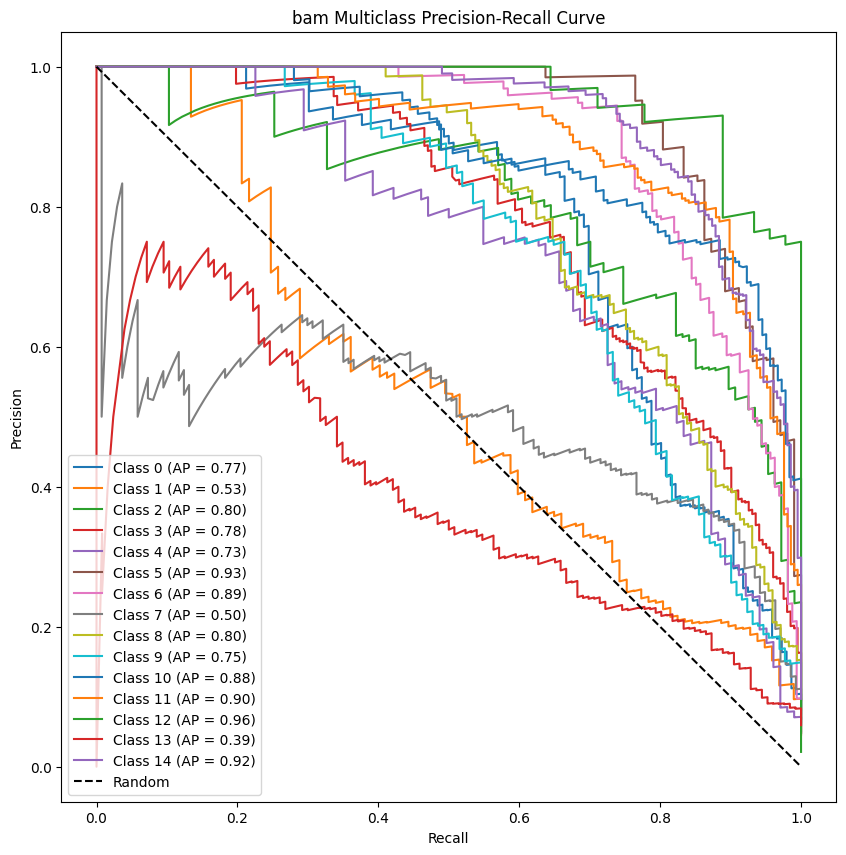

In [162]:
n_classes = len(np.unique(test_data.classes))

# Convert labels to one-hot encoding
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))

# Predicted probabilities (assumed softmax output)
y_pred = bam_predictions  # Shape: (num_samples, num_classes)

# Compute Precision-Recall curve and Average Precision (AP) for each class
precision = dict()
recall = dict()
average_precision = dict()

plt.figure(figsize=(10, 10))
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])
    
    # Plot Precision-Recall curve for each class
    plt.plot(recall[i], precision[i], label=f'Class {i} (AP = {average_precision[i]:.2f})')

# Random classifier baseline
plt.plot([0, 1], [1, 0], 'k--', label='Random')

# Labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('bam Multiclass Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


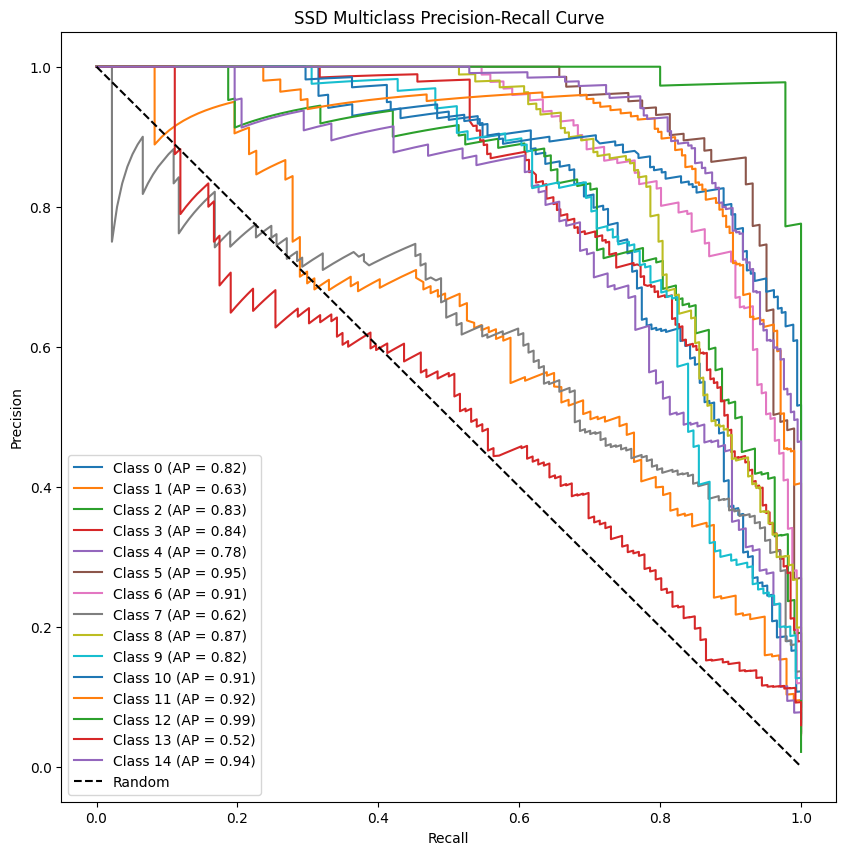

In [163]:
n_classes = len(np.unique(test_data.classes))

# Convert labels to one-hot encoding
y_true = label_binarize(test_data.classes, classes=np.arange(n_classes))

# Predicted probabilities (assumed softmax output)
y_pred = cbam_predictions  # Shape: (num_samples, num_classes)

# Compute Precision-Recall curve and Average Precision (AP) for each class
precision = dict()
recall = dict()
average_precision = dict()

plt.figure(figsize=(10, 10))
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])
    
    # Plot Precision-Recall curve for each class
    plt.plot(recall[i], precision[i], label=f'Class {i} (AP = {average_precision[i]:.2f})')

# Random classifier baseline
plt.plot([0, 1], [1, 0], 'k--', label='Random')

# Labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('SSD Multiclass Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()
